In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks
import numpy as np
import pandas as pd



np.random.seed(0)



In [ ]:
pip install tensorflow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
data = pd.read_csv("/content/weatherAUS.csv")
data.head()


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76113 entries, 0 to 76112
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           76113 non-null  object 
 1   Location       76113 non-null  object 
 2   MinTemp        75001 non-null  float64
 3   MaxTemp        75175 non-null  float64
 4   Rainfall       73884 non-null  float64
 5   Evaporation    37280 non-null  float64
 6   Sunshine       30464 non-null  float64
 7   WindGustDir    69983 non-null  object 
 8   WindGustSpeed  69991 non-null  float64
 9   WindDir9am     69197 non-null  object 
 10  WindDir3pm     73308 non-null  object 
 11  WindSpeed9am   74732 non-null  float64
 12  WindSpeed3pm   74118 non-null  float64
 13  Humidity9am    74292 non-null  float64
 14  Humidity3pm    73864 non-null  float64
 15  Pressure9am    65523 non-null  float64
 16  Pressure3pm    65576 non-null  float64
 17  Cloud9am       46036 non-null  float64
 18  Cloud3

<Axes: xlabel='RainTomorrow', ylabel='count'>

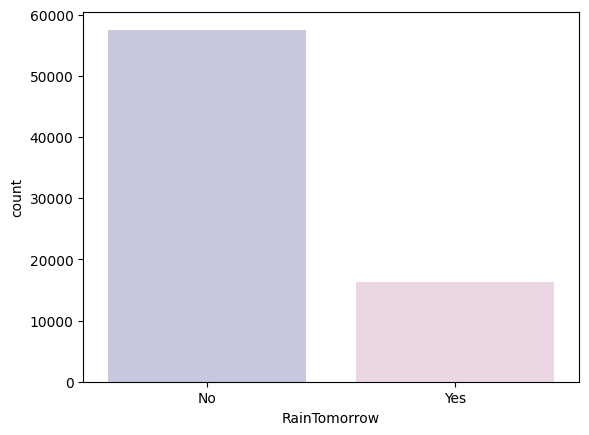

In [ ]:

#first of all let us evaluate the target and find out if our data is imbalanced or not
cols= ["#C2C4E2","#EED4E5"]
sns.countplot(x= data["RainTomorrow"], palette= cols)


<ipython-input-7-8a2cf40265ea>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = data.corr()


<Axes: >

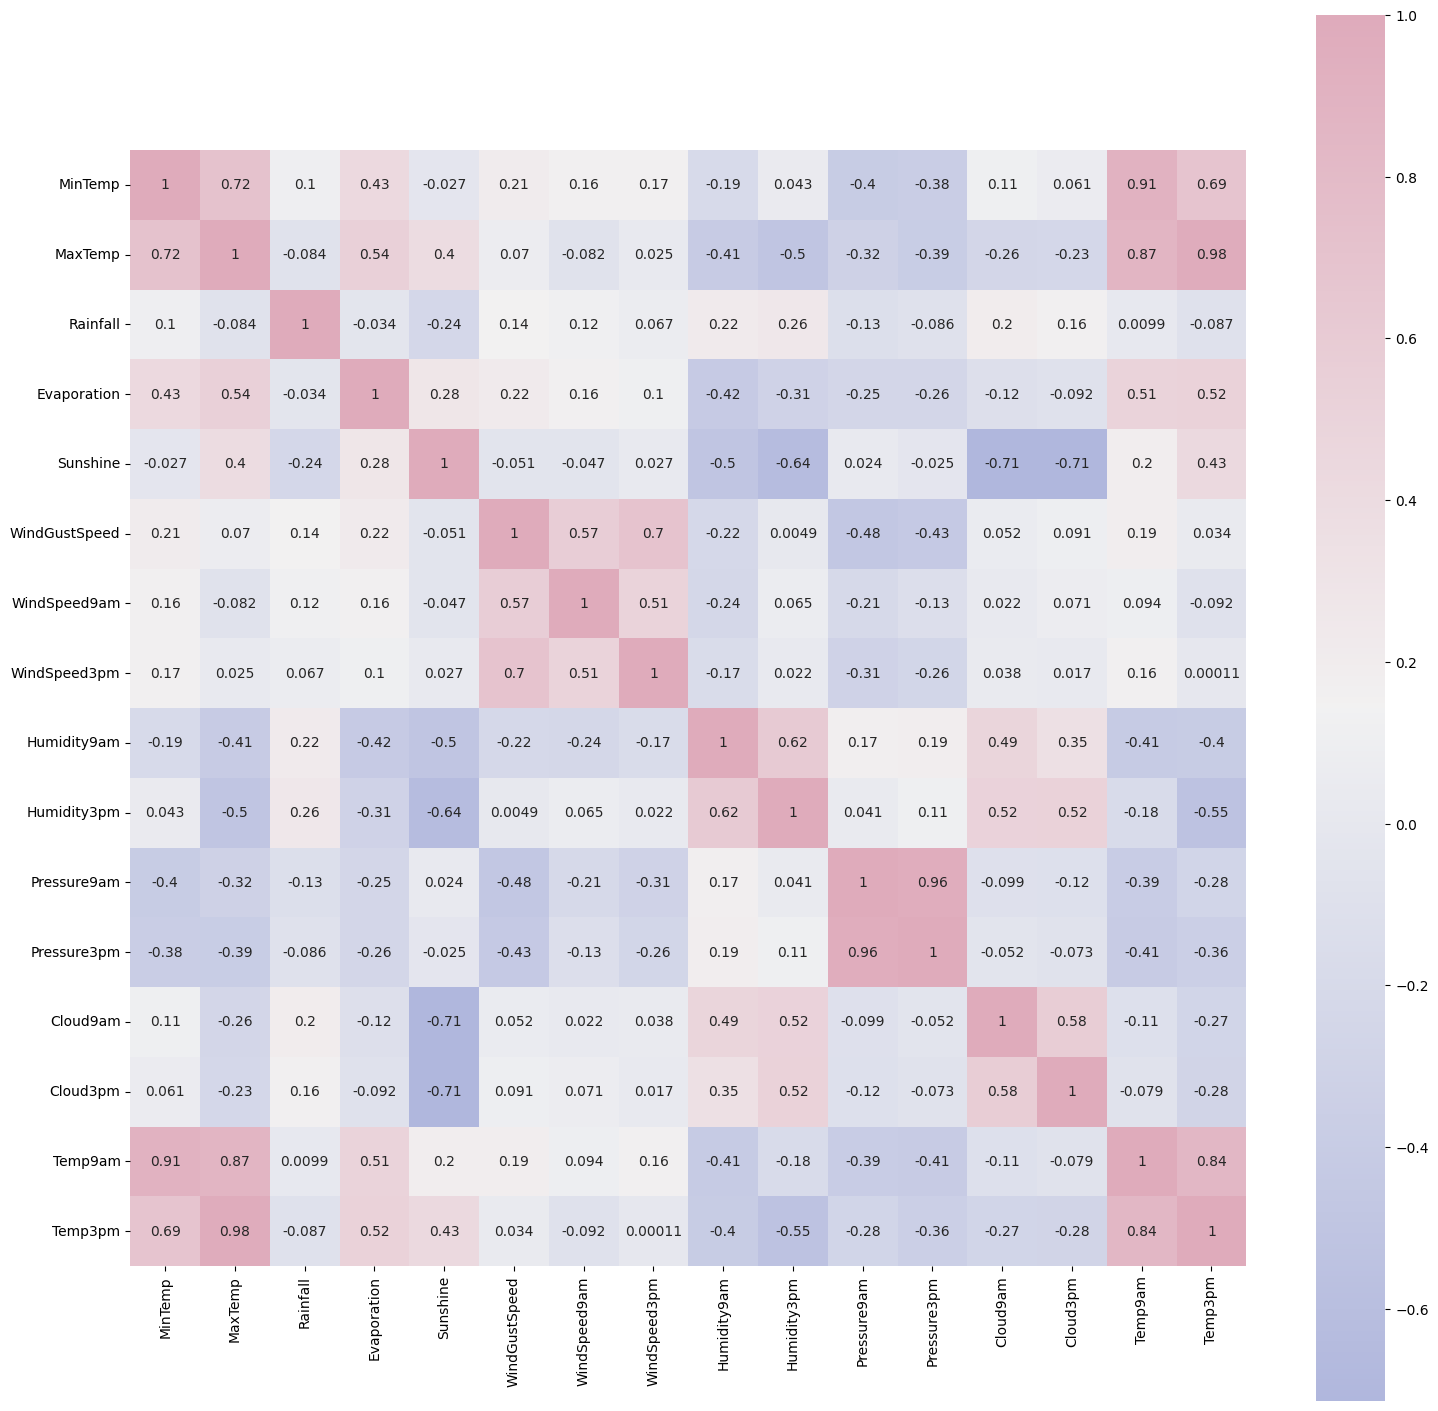

In [ ]:

# Correlation amongst numeric attributes
corrmat = data.corr()
cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=True)


In [ ]:
#Parsing datetime
#exploring the length of date objects
lengths = data["Date"].str.len()
lengths.value_counts()


10    145460
Name: Date, dtype: int64

In [ ]:
#There don't seem to be any error in dates so parsing values into datetime
data['Date']= pd.to_datetime(data["Date"])
#Creating a collumn of year
data['year'] = data.Date.dt.year

# function to encode datetime into cyclic parameters.
#As I am planning to use this data in a neural network I prefer the months and days in a cyclic continuous feature.

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

data['month'] = data.Date.dt.month
data = encode(data, 'month', 12)

data['day'] = data.Date.dt.day
data = encode(data, 'day', 31)

data.head()


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,21.8,No,No,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,24.3,No,No,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,23.2,No,No,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,26.5,No,No,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,29.7,No,No,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


Text(0.5, 0, 'Days In Year')

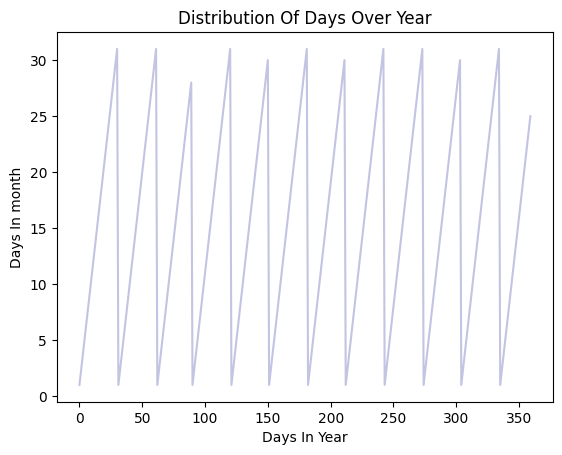

In [ ]:

# roughly a year's span section
section = data[:360]
tm = section["day"].plot(color="#C2C4E2")
tm.set_title("Distribution Of Days Over Year")
tm.set_ylabel("Days In month")
tm.set_xlabel("Days In Year")


Text(0.5, 0, 'Sine Encoded Months')

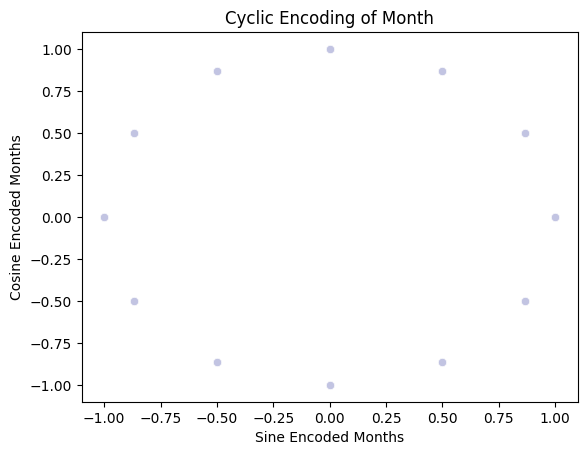

In [ ]:

cyclic_month = sns.scatterplot(x="month_sin",y="month_cos",data=data, color="#C2C4E2")
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")


Text(0.5, 0, 'Sine Encoded Day')

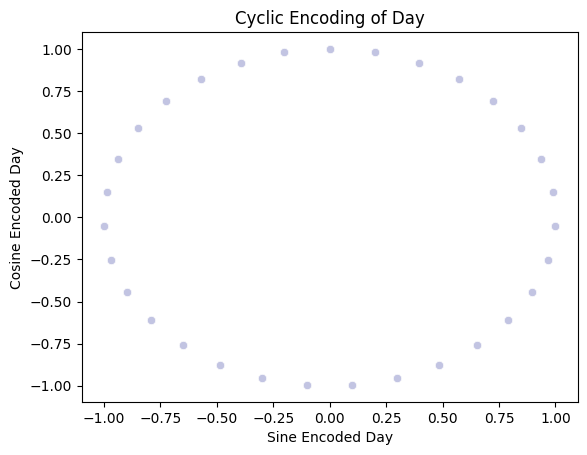

In [ ]:

cyclic_day = sns.scatterplot(x='day_sin',y='day_cos',data=data, color="#C2C4E2")
cyclic_day.set_title("Cyclic Encoding of Day")
cyclic_day.set_ylabel("Cosine Encoded Day")
cyclic_day.set_xlabel("Sine Encoded Day")


In [ ]:

# Get list of categorical variables
s = (data.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)


Categorical variables:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [ ]:
# Missing values in categorical variables

for i in object_cols:
    print(i, data[i].isnull().sum())


Location 0
WindGustDir 6130
WindDir9am 6916
WindDir3pm 2805
RainToday 2230
RainTomorrow 2229


In [ ]:
# Filling missing values with mode of the column in value

for i in object_cols:
    data[i].fillna(data[i].mode()[0], inplace=True)


In [ ]:
# Get list of neumeric variables
t = (data.dtypes == "float64")
num_cols = list(t[t].index)

print("Neumeric variables:")
print(num_cols)

Neumeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [ ]:
# Missing values in numeric variables

for i in num_cols:
    print(i, data[i].isnull().sum())


MinTemp 1112
MaxTemp 938
Rainfall 2229
Evaporation 38833
Sunshine 45649
WindGustSpeed 6122
WindSpeed9am 1381
WindSpeed3pm 1995
Humidity9am 1821
Humidity3pm 2249
Pressure9am 10590
Pressure3pm 10537
Cloud9am 30077
Cloud3pm 31035
Temp9am 1481
Temp3pm 1963
month_sin 0
month_cos 0
day_sin 0
day_cos 0


In [ ]:
# Filling missing values with median of the column in value

for i in num_cols:
    data[i].fillna(data[i].median(), inplace=True)

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76113 entries, 0 to 76112
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           76113 non-null  datetime64[ns]
 1   Location       76113 non-null  object        
 2   MinTemp        76113 non-null  float64       
 3   MaxTemp        76113 non-null  float64       
 4   Rainfall       76113 non-null  float64       
 5   Evaporation    76113 non-null  float64       
 6   Sunshine       76113 non-null  float64       
 7   WindGustDir    76113 non-null  object        
 8   WindGustSpeed  76113 non-null  float64       
 9   WindDir9am     76113 non-null  object        
 10  WindDir3pm     76113 non-null  object        
 11  WindSpeed9am   76113 non-null  float64       
 12  WindSpeed3pm   76113 non-null  float64       
 13  Humidity9am    76113 non-null  float64       
 14  Humidity3pm    76113 non-null  float64       
 15  Pressure9am    7611

In [ ]:

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for i in object_cols:
    data[i] = label_encoder.fit_transform(data[i])

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76113 entries, 0 to 76112
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           76113 non-null  datetime64[ns]
 1   Location       76113 non-null  int64         
 2   MinTemp        76113 non-null  float64       
 3   MaxTemp        76113 non-null  float64       
 4   Rainfall       76113 non-null  float64       
 5   Evaporation    76113 non-null  float64       
 6   Sunshine       76113 non-null  float64       
 7   WindGustDir    76113 non-null  int64         
 8   WindGustSpeed  76113 non-null  float64       
 9   WindDir9am     76113 non-null  int64         
 10  WindDir3pm     76113 non-null  int64         
 11  WindSpeed9am   76113 non-null  float64       
 12  WindSpeed3pm   76113 non-null  float64       
 13  Humidity9am    76113 non-null  float64       
 14  Humidity3pm    76113 non-null  float64       
 15  Pressure9am    7611

In [ ]:
# Prepairing attributes of scale data

features = data.drop(['RainTomorrow', 'Date','day', 'month'], axis=1) # dropping target and extra columns

target = data['RainTomorrow']

#Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names)

features.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,76113.0,4.182244e-17,1.000007,-1.617628,-0.831595,-0.045562,0.871477,1.657510
MinTemp,76113.0,-1.643024e-16,1.000007,-3.199271,-0.707547,0.020554,0.781015,3.337459
MaxTemp,76113.0,3.017190e-16,1.000007,-3.924614,-0.674915,-0.065596,0.630768,3.633839
Rainfall,76113.0,1.075434e-16,1.000007,-0.280056,-0.280056,-0.280056,-0.206717,45.067864
Evaporation,76113.0,-4.331610e-17,1.000007,-1.636189,-0.135691,-0.135691,-0.135691,47.812037
Sunshine,76113.0,1.375660e-15,1.000007,-3.166383,0.125731,0.125731,0.125731,2.726906
WindGustDir,76113.0,-1.657961e-16,1.000007,-1.777551,-0.923494,0.144076,0.998133,1.425161
WindGustSpeed,76113.0,-6.870830e-17,1.000007,-2.401286,-0.662530,-0.082945,0.569088,6.872079
WindDir9am,76113.0,-1.549671e-17,1.000007,-1.622812,-0.967145,-0.092921,0.999859,1.655527
WindDir3pm,76113.0,-7.767025e-17,1.000007,-1.728382,-0.837206,0.053971,0.945147,1.613530


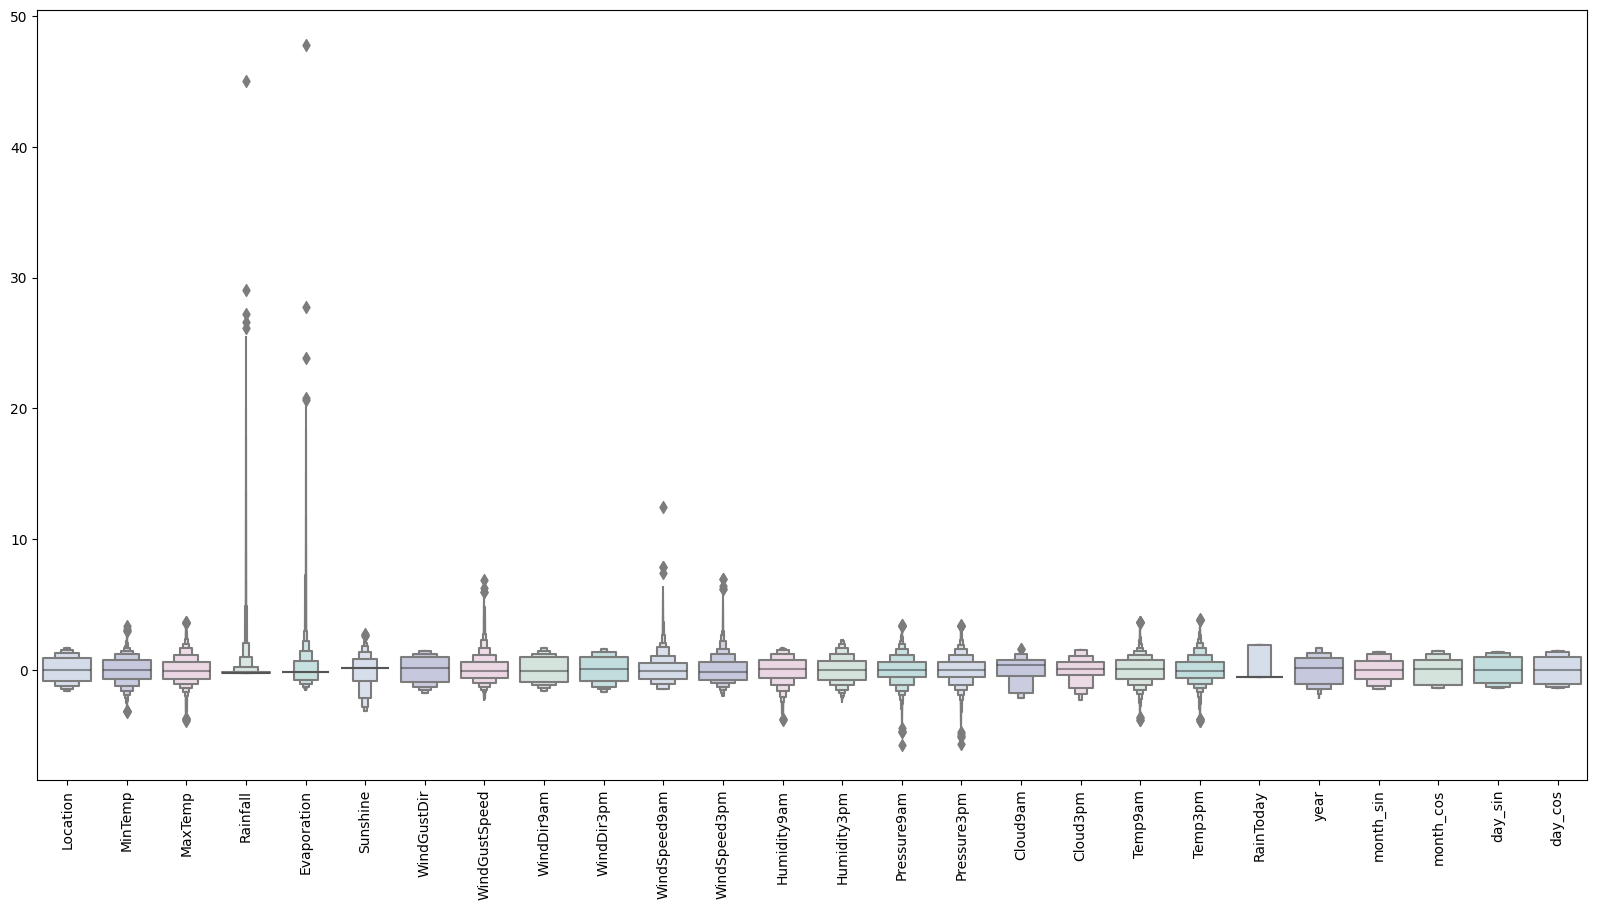

In [ ]:

#Detecting outliers
#looking at the scaled features
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()


In [ ]:
#full data for
features["RainTomorrow"] = target

#Dropping with outlier

features = features[(features["MinTemp"]<2.3)&(features["MinTemp"]>-2.3)]
features = features[(features["MaxTemp"]<2.3)&(features["MaxTemp"]>-2)]
features = features[(features["Rainfall"]<4.5)]
features = features[(features["Evaporation"]<2.8)]
features = features[(features["Sunshine"]<2.1)]
features = features[(features["WindGustSpeed"]<4)&(features["WindGustSpeed"]>-4)]
features = features[(features["WindSpeed9am"]<4)]
features = features[(features["WindSpeed3pm"]<2.5)]
features = features[(features["Humidity9am"]>-3)]
features = features[(features["Humidity3pm"]>-2.2)]
features = features[(features["Pressure9am"]< 2)&(features["Pressure9am"]>-2.7)]
features = features[(features["Pressure3pm"]< 2)&(features["Pressure3pm"]>-2.7)]
features = features[(features["Cloud9am"]<1.8)]
features = features[(features["Cloud3pm"]<2)]
features = features[(features["Temp9am"]<2.3)&(features["Temp9am"]>-2)]
features = features[(features["Temp3pm"]<2.3)&(features["Temp3pm"]>-2)]


features.shape


(65136, 27)

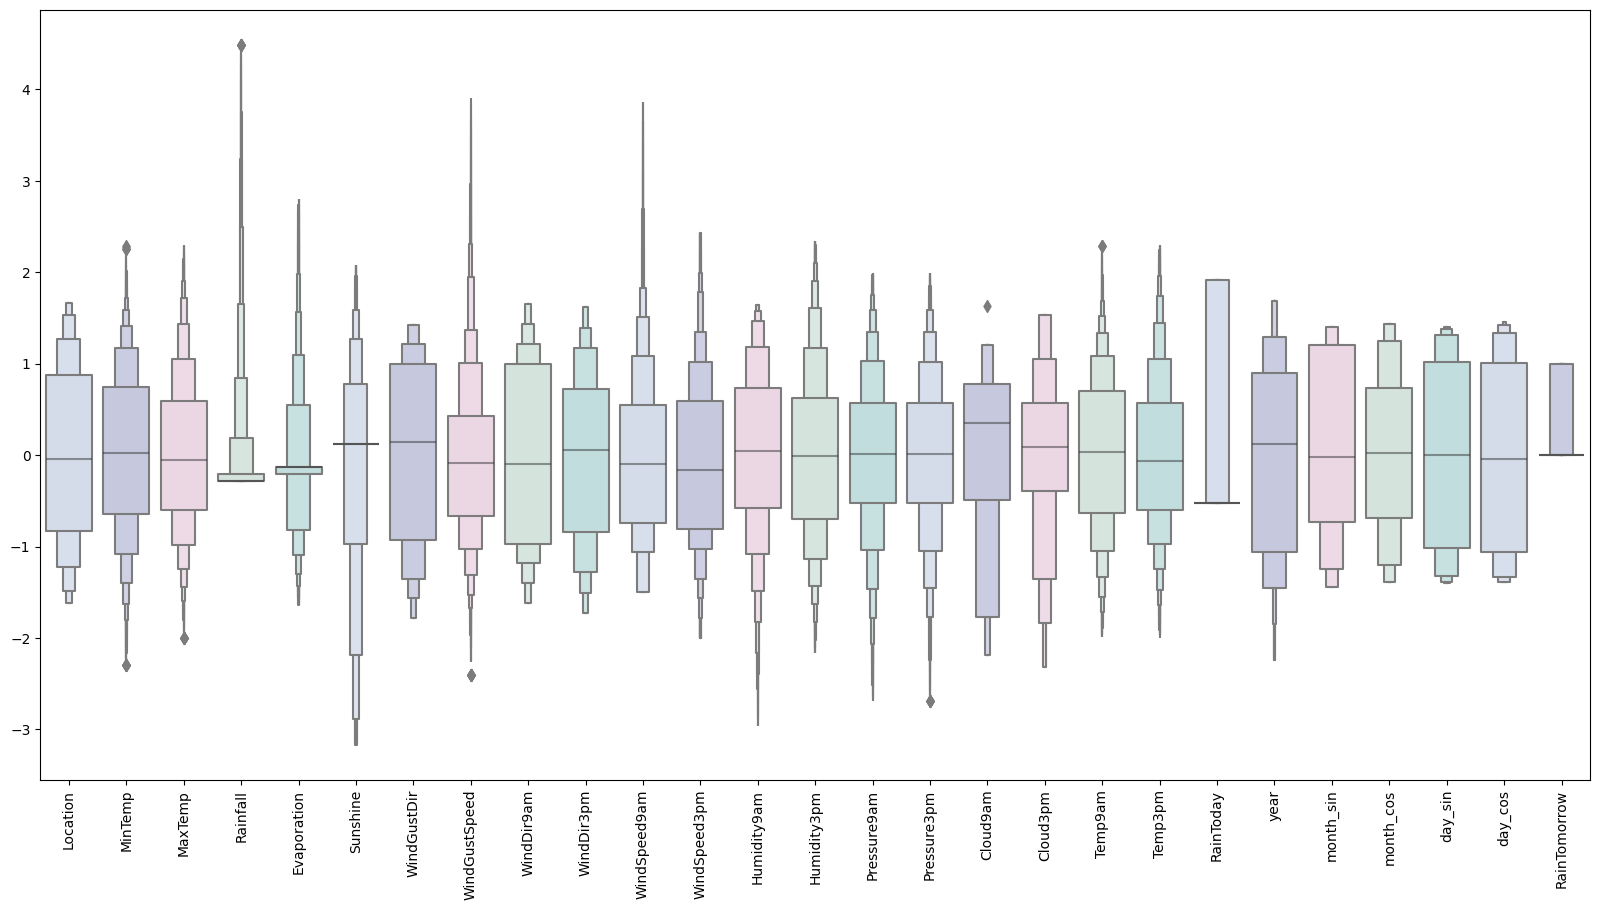

In [ ]:
#looking at the scaled features without outliers

plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()


In [ ]:
X = features.drop(["RainTomorrow"], axis=1)
y = features["RainTomorrow"]

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X.shape


(65136, 26)

In [ ]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 26))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 10, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/10
1303/1303 [==============================] - 5s 3ms/step - loss: 0.5286 - accuracy: 0.7891 - val_loss: 0.4010 - val_accuracy: 0.7902
Epoch 2/10
1303/1303 [==============================] - 4s 3ms/step - loss: 0.4261 - accuracy: 0.7909 - val_loss: 0.3894 - val_accuracy: 0.7902
Epoch 3/10
1303/1303 [==============================] - 3s 2ms/step - loss: 0.4168 - accuracy: 0.8090 - val_loss: 0.3843 - val_accuracy: 0.8388
Epoch 4/10
1303/1303 [==============================] - 3s 2ms/step - loss: 0.4124 - accuracy: 0.8122 - val_loss: 0.3799 - val_accuracy: 0.8442
Epoch 5/10
1303/1303 [==============================] - 4s 3ms/step - loss: 0.4081 - accuracy: 0.8159 - val_loss: 0.3758 - val_accuracy: 0.8463
Epoch 6/10
1303/1303 [==============================] - 3s 3ms/step - loss: 0.4055 - accuracy: 0.8137 - val_loss: 0.3726 - val_accuracy: 0.8478
Epoch 7/10
1303/1303 [==============================] - 3s 2ms/step - loss: 0.4036 - accuracy: 0.8142 - val_loss: 0.3711 - val_accuracy:

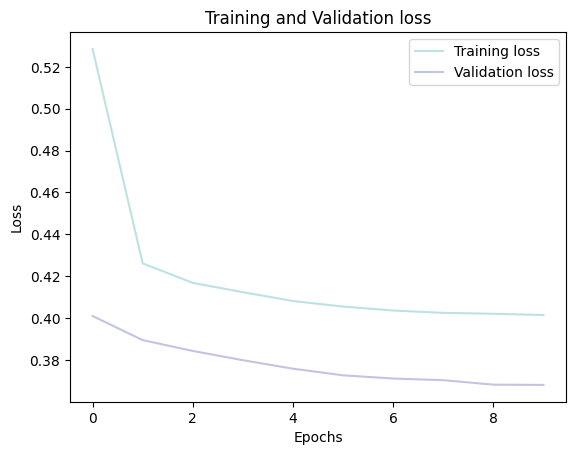

In [ ]:

history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()


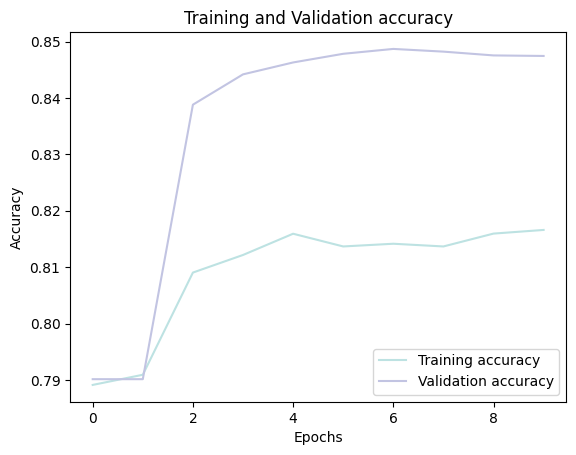

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)


408/408 [==============================] - 1s 3ms/step


<Axes: >

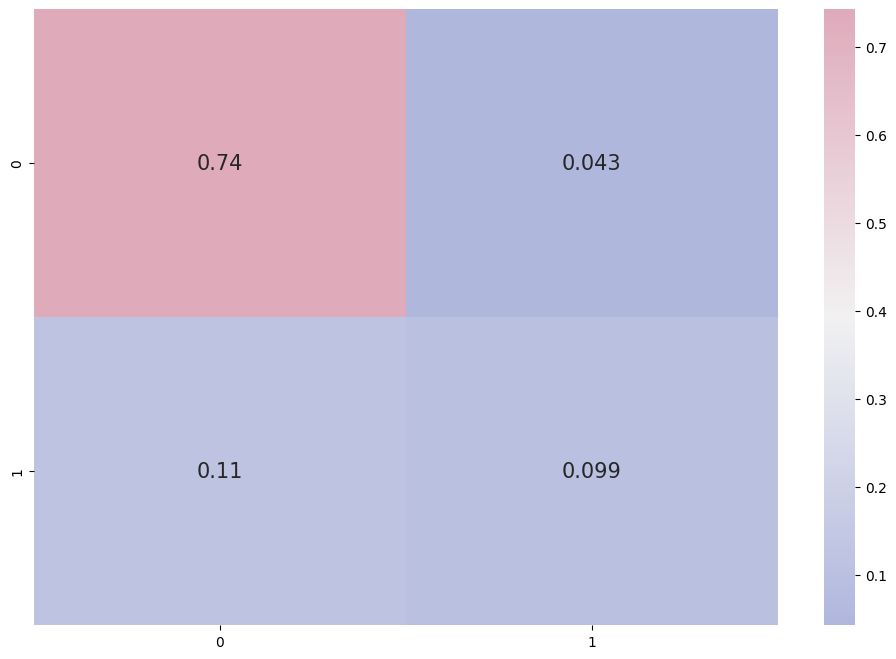

In [ ]:
# confusion matrix
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     10235
           1       0.70      0.46      0.56      2793

    accuracy                           0.84     13028
   macro avg       0.78      0.70      0.73     13028
weighted avg       0.83      0.84      0.83     13028

